In [21]:
# Import Libraries

import pandas as pd
import numpy as np

import math
from scipy.stats import randint, uniform
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns

from pickle import dump
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data

df = pd.read_csv('/content/drive/MyDrive/Laptop-Prices/cleaned_data2.csv')
df.head()

,MRP,RAM_Size,RAM_Type,Display,Processor,Storage,OS,Brand
0,36990,8,DDR4,14.0,Intel Core i3,256 GB SSD,Windows,Lenovo
1,39990,8,DDR4,15.6,Intel Core i3,512 GB SSD,Windows,Lenovo
2,32990,8,DDR4,15.6,Intel Core i3,512 GB SSD,Windows,ASUS
3,49990,8,DDR4,15.6,AMD Ryzen 5 Hexa Core,512 GB SSD,Windows,HP
4,49990,8,DDR4,15.6,Intel Core i5,512 GB SSD,Windows,ASUS


In [3]:
df.shape

(423, 8)

In [4]:
df.Storage.value_counts()

512 GB SSD              232
128 GB SSD               78
256 GB SSD               69
1 TB HDD, 256 GB SSD     26
1 TB HDD                 14
1 TB HDD, 512 GB SSD      2
1 TB HDD, 128 GB SSD      2
Name: Storage, dtype: int64

In [5]:
# Define the mapping dictionaries

dict_ram_type = {'DDR4':0, 'DDR5':1, 'LPDDR4':2,'Unified Memory':3, 'LPDDR4X':4, 'LPDDR5':5, 'LPDDR3':6}

dict_processor = {'AMD Athlon Dual Core':0,                
                  'AMD Ryzen 3':1, 
                  'AMD Ryzen 3 Dual Core':2,
                  'AMD Ryzen 3 Quad Core':3, 
                  'AMD Ryzen 3 Hexa Core':4, 
                  'AMD Ryzen 5':5, 
                  'AMD Ryzen 5 Dual Core':6, 
                  'AMD Ryzen 5 Quad Core':7,
                  'AMD Ryzen 5 Hexa Core':8, 
                  'AMD Ryzen 7 Octa Core':9, 
                  'AMD Ryzen 7 Quad Core':10, 
                  'AMD Ryzen 9 Octa Core':11,           
                  'Intel Core i3':12,             
                  'Intel Core i5':13, 
                  'Intel Evo Core i5':14, 
                  'Intel Core i7':15, 
                  'Intel Core i9':16, 
                  'Intel Celeron Dual Core':17, 
                  'Intel Celeron Quad Core':18, 
                  'Intel Pentium Silver':19,
                  'Intel Pentium Quad Core':20,
                  'M1':21,
                  'M1 Pro':22, 
                  'M1 Max':23, 
                  'M2':24, 
                  'Qualcomm Snapdragon 7c Gen 2':25}

dict_os = {'Windows':0, 'Mac OS':1,
           'DOS':3, 'Chrome':4}

dict_brand = {'ASUS':0, 'Lenovo':1,
              'HP':3, 'DELL':4,
              'acer':5, 'MSI':6,
              'APPLE':7, 'Infinix':8,
              'realme':9, 'RedmiBook':10,
              'SAMSUNG':11, 'Ultimus':12,
              'ALIENWARE':13, 'Nokia':14,
              'GIGABYTE':15, 'Vaio': 16}
dicts_cols = {'RAM_Type':dict_ram_type, 'Processor':dict_processor, 'OS':dict_os, 'Brand':dict_brand}


In [6]:
# replace the categorical values with their numerical labels
df = df.replace(dicts_cols)

le = LabelEncoder()
df['Storage'] = le.fit_transform(df['Storage'])
df.head(2)

,MRP,RAM_Size,RAM_Type,Display,Processor,Storage,OS,Brand
0,36990,8,0,14.0,12,5,0,1
1,39990,8,0,15.6,12,6,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MRP        423 non-null    int64  
 1   RAM_Size   423 non-null    int64  
 2   RAM_Type   423 non-null    int64  
 3   Display    423 non-null    float64
 4   Processor  423 non-null    int64  
 5   Storage    423 non-null    int64  
 6   OS         423 non-null    int64  
 7   Brand      423 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 26.6 KB


In [8]:
# Separate the target variable from the features

X = df.drop(columns=['MRP'], axis=1)
y = np.log(df['MRP'])

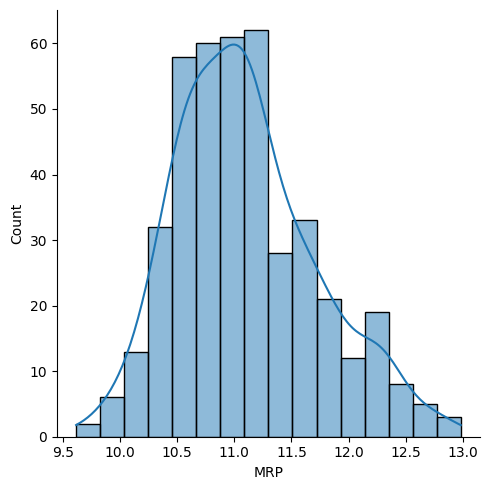

In [9]:
sns.displot(y, kde=True);

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((296, 7), (296,), (127, 7), (127,))

In [11]:
# Power-transform RAM Size and Display columns only

scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_train_scaled[['Display', 'RAM_Size']] = scaler.fit_transform(X_train_scaled[['Display', 'RAM_Size']])
X_test_scaled = X_test.copy()
X_test_scaled[['Display', 'RAM_Size']] = scaler.transform(X_test_scaled[['Display', 'RAM_Size']])

In [12]:
# Create new dataframes with the scaled data and original column names

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Base Models

In [13]:
# Putting models into a dictionary

models = {
          "Random Forest" : RandomForestRegressor(),
          "XGBoost": XGBRegressor(),
          "Gradient Boost" : GradientBoostingRegressor(),
          "Ridge" : Ridge ()
          }
          
# Function that will fit and score models

def fit_and_score(models, X_train, X_test, y_train, y_test):

    # Setting up a random seed

    random_state=42
 
    # Making a dictionary to keep model scores

    model_scores = {}

    # Looping through models
    
    for name, model in models.items():
        # Fitting the models to the data
        model.fit(X_train, y_train)
        # Evaluating the model and appending its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [14]:
%%time
scores = fit_and_score(models = models,
                      X_train = X_train,
                      X_test = X_test,
                      y_train = y_train,
                      y_test = y_test)
scores

CPU times: user 416 ms, sys: 12.8 ms, total: 429 ms
Wall time: 378 ms


{'Random Forest': 0.8408779112446196,
 'XGBoost': 0.8580264975283868,
 'Gradient Boost': 0.8621939297235232,
 'Ridge': 0.5795957367098781}

**XGBoost**

In [24]:
XGB = XGBRegressor()

XGB.fit(X_train, y_train)
prediction = XGB.predict(X_test)

# evaluate the model
mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediction)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R-squared: ", r2)

MAE:  0.1657141464665079
MSE:  0.048516012131371966
RMSE:  0.2202635061270295
R-squared:  0.8580264975283868


**Gradient Boosting**

In [25]:
GBR = GradientBoostingRegressor()

GBR.fit(X_train, y_train)
prediction = GBR.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediction)

print("MAE: ", mae)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R-squared: ", r2)

MAE:  0.17381410331965777
MSE:  0.04676302889593545
RMSE:  0.2162476101508071
R-squared:  0.8631562919771768


### Hyperparameter Tuning

In [ ]:
# Create a Gradient Boosting Regressor object
gbr = GradientBoostingRegressor()

# Define the hyperparameter space
param_dist = {"n_estimators": randint(100, 500),
              "max_features": randint(1, 10),
              "max_depth": [None] + list(randint(1, 11).rvs(10)),
              "min_samples_leaf": randint(1, 10)}


# Define the Halving Random Search cross-validation object
hrscv = HalvingRandomSearchCV(gbr, param_distributions=param_dist, n_candidates=100,
                              factor=2, min_resources='exhaust', 
                              random_state=42, n_jobs=-1)

# Fit the Halving Random Search cross-validation object to the data 
hrscv.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters for Gradient Boosting Regressor: {hrscv.best_params_}")

Best hyperparameters for Gradient Boosting Regressor: {'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 478}


In [17]:
# Create and train the model with the tuned hyperparameters
gbr = GradientBoostingRegressor(max_features = 4, min_samples_leaf = 2, n_estimators = 478, random_state=42)
gbr.fit(X_train, y_train)

# Predictions
gbr_pred = gbr.predict(X_test)

# Back-transform predicted values to original scale
y_pred_orig = np.exp(gbr_pred)

# Evaluate the model 
mae = mean_absolute_error(y_test,gbr_pred)
mse= mean_squared_error(y_test, gbr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, gbr_pred)

print("Mean Absolute Error: {:.4f}".format(mae))
print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error :{:.4f}".format(rmse))
print("R-Squared :{:.4f}".format(r2))

Mean Absolute Error: 0.1534
Mean Squared Error: 0.0427
Root Mean Squared Error :0.2067
R-Squared :0.8750


In [18]:
print(y_pred_orig)

[111878.02474918  85966.45982977  71936.35002333  75873.74347313
  78610.7744282   38089.60994035  53556.63305777  57971.99209666
 156629.3700875   59810.73502655  42062.14907589  38623.45106546
  68100.55897944  51255.98179883  53556.63305777 142532.38589242
  75243.74326224  73648.46122934 243539.99502153 208074.06970458
  34124.18969853  61600.05942806  91368.45717021  37438.47993027
  57971.99209666 175338.44946748  54795.94656096  33076.46116498
  66601.92919762 111878.02474918  58558.54361363  21720.45233006
  57525.03230027  41571.20637763  66900.25502172  40696.41816961
  69961.58300074  57059.39202462  56721.179356    68920.66855983
  81075.85316442 130805.68883236 101679.27946159 181426.0727614
  78005.32056007  44883.54934649  44128.50488455  59810.73502655
 195896.3540418  181426.0727614   47053.10130373  74813.25080525
  40489.67122597 122566.29156132  67397.86790506 146855.78944435
  51827.71925217  38236.44658775 117777.02317244  38623.45106546
 145267.49886913  44086.86

In [20]:
# Create a XGBoost Regressor object
xgbr = XGBRegressor()

# Define the hyperparameter space
param_dist = {"n_estimators": randint(100, 500),
              "max_depth": [None] + list(randint(1, 11).rvs(10)),
              "learning_rate": uniform(0.01, 0.3),
              "gamma": uniform(0, 10)}

# Define the Halving Random Search cross-validation object
hrscv = HalvingRandomSearchCV(xgbr, param_distributions=param_dist, n_candidates=100,
                              factor=2, min_resources='exhaust', 
                              random_state=42, n_jobs=-1)

# Fit the Halving Random Search cross-validation object to the data 
hrscv.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters for XGBoost Regressor: {hrscv.best_params_}")

Best hyperparameters for XGBoost Regressor: {'gamma': 0.15966252220214194, 'learning_rate': 0.0792681476866447, 'max_depth': 8, 'n_estimators': 363}


In [26]:
# Create and train the model with the tuned hyperparameters
xgbr = XGBRegressor(gamma= 0.15966252220214194, learning_rate = 0.0792681476866447 , max_depth = 8, n_estimators = 363)
xgbr.fit(X_train, y_train)

# Predictions
xgbr_pred = xgbr.predict(X_test)

# Back-transform predicted values to original scale
y_pred_orig = np.exp(xgbr_pred)

# Evaluate the model 
mae = mean_absolute_error(y_test,xgbr_pred)
mse= mean_squared_error(y_test, xgbr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgbr_pred)

print("Mean Absolute Error: {:.4f}".format(mae))
print("Mean Squared Error: {:.4f}".format(mse))
print("Root Mean Squared Error :{:.4f}".format(rmse))
print("R-Squared :{:.4f}".format(r2))

Mean Absolute Error: 0.1815
Mean Squared Error: 0.0507
Root Mean Squared Error :0.2251
R-Squared :0.8517


In [ ]:
print(y_pred_orig)

[105573.484 104733.23   67688.53   79563.85   87154.26   48621.055
  48735.953  51951.78  109772.664  61963.56   46112.227  46992.75
  81719.01   56031.918  48735.953 139825.88   83239.43   84159.2
 175871.02  171359.4    50630.95   51791.26   64538.61   36849.98
  51951.78  159431.58   54277.027  36739.688  54050.473 105573.484
  54609.066  29748.621  52682.26   47263.043  85497.56   52107.74
  59099.383  50878.92   48279.363  77687.555  88311.97  128958.91
  95161.    136966.64   95477.07   48127.707  44824.293  61963.56
 140539.62  136966.64   53858.188  53050.     45680.22  109772.664
  51940.586 131017.71   49952.25   47234.297 135163.12   46992.75
 168303.4    51184.31   81719.01   52107.74   70591.11   53726.293
  60006.65   50713.87   82634.27  103093.76   30449.559  36849.98
  51387.523  17123.78   33132.152  53911.48  110595.12   87154.26
  24327.56  136966.64   47558.52  106460.484  50713.87   51387.523
  50760.715  81719.01   49666.574 105758.91   31389.357  82634.27
  5086

In [30]:
df.to_csv('cleaned_data3.csv', index=False)    

In [29]:
# Save the models

dump(dicts_cols, open('dicts.pkl', 'wb'))
dump(le, open('encoder.pkl', 'wb'))
dump(scaler, open('scaler.pkl', 'wb'))
dump(gbr, open('gbr_model.pkl', 'wb'))
dump(xgbr, open('xgbr_model.pkl', 'wb'))